# Path planning using A* Notebook



In [1]:
import os
import sys
import time
import math
from matplotlib import colors

# Adding the src folder in the current directory as it contains the script
# with the Thymio class
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

print(sys.executable)

import math
from matplotlib import colors

%matplotlib inline

/Users/Baudoin/anaconda3/bin/python


In [2]:
import cv2
import time

import numpy as np

%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets

# Image Processing

#### Map loading from image file

In [3]:
# Load map form image file
img1 = cv2.imread('/Images/mapcolor.jpg', cv2.IMREAD_COLOR)

# If the image path is wrong, the resulting img will be none
if img1 is None:
    print('Open Error')
else:
    print('Image Loaded')
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

Open Error


### Rescale image

In [4]:
# Define ratio of rescaling
scale_percent = 10 # percent of original size
width = int(img1.shape[1] * scale_percent / 100)
height = int(img1.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
img = cv2.resize(img1, dim, interpolation = cv2.INTER_AREA)

AttributeError: 'NoneType' object has no attribute 'shape'

<IPython.core.display.Javascript object>


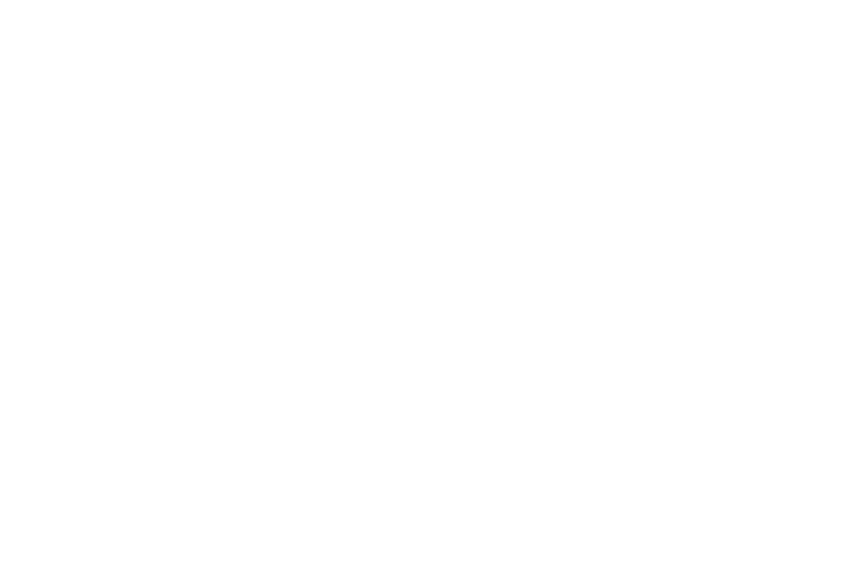

NameError: name 'img' is not defined

In [5]:

plt.figure(figsize=(6,4))
plt.imshow(img[:,:,::-1])
plt.title("Original")


# Gaussian Filtering with a 10x10 kernel
gauss = cv2.GaussianBlur(img,(9,9),0)

plt.figure(figsize=(6,4))
plt.imshow(gauss[:,:,::-1])
plt.title("Gaussian")

plt.tight_layout()
plt.show()

In [6]:
# Converting the original image to black and white

# Bilateral Filtering 
bilateral = cv2.bilateralFilter(img,9,75,75)

bw_img = cv2.cvtColor(bilateral, cv2.COLOR_BGR2GRAY)

hist, bins = np.histogram(bw_img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.figure()
plt.hist(bw_img.flatten(),256,[0,256], color = 'r')
plt.plot(cdf_normalized, color="b")
plt.xlim([0,256])
plt.legend(('histogram', "cdf"), loc = 'upper left')
plt.show()

NameError: name 'img' is not defined

In [7]:
ret,thresh = cv2.threshold(bw_img,165, 220,cv2.THRESH_BINARY)

plt.title('Global Thresholding v = 127')
plt.figure(figsize=(8,5))
plt.imshow(thresh,'gray')
plt.show()

NameError: name 'bw_img' is not defined

In [8]:
# Morphological
thresh.shape[0]

NameError: name 'thresh' is not defined

In [9]:
H = thresh.shape[1] # Size of the map
L = thresh.shape[0]
max_val = 71

def create_empty_plot(x_val=L,y_val = H):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    #major_ticks = np.arange(0, max_val+1, 5)
    #minor_ticks = np.arange(0, max_val+1, 1)
    #ax.set_xticks(major_ticks)
    #ax.set_xticks(minor_ticks, minor=True)
    #ax.set_yticks(major_ticks)
    #ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,y_val])
    ax.set_xlim([-1,x_val])
    ax.grid(True)
    
    return fig, ax

NameError: name 'thresh' is not defined

<IPython.core.display.Javascript object>


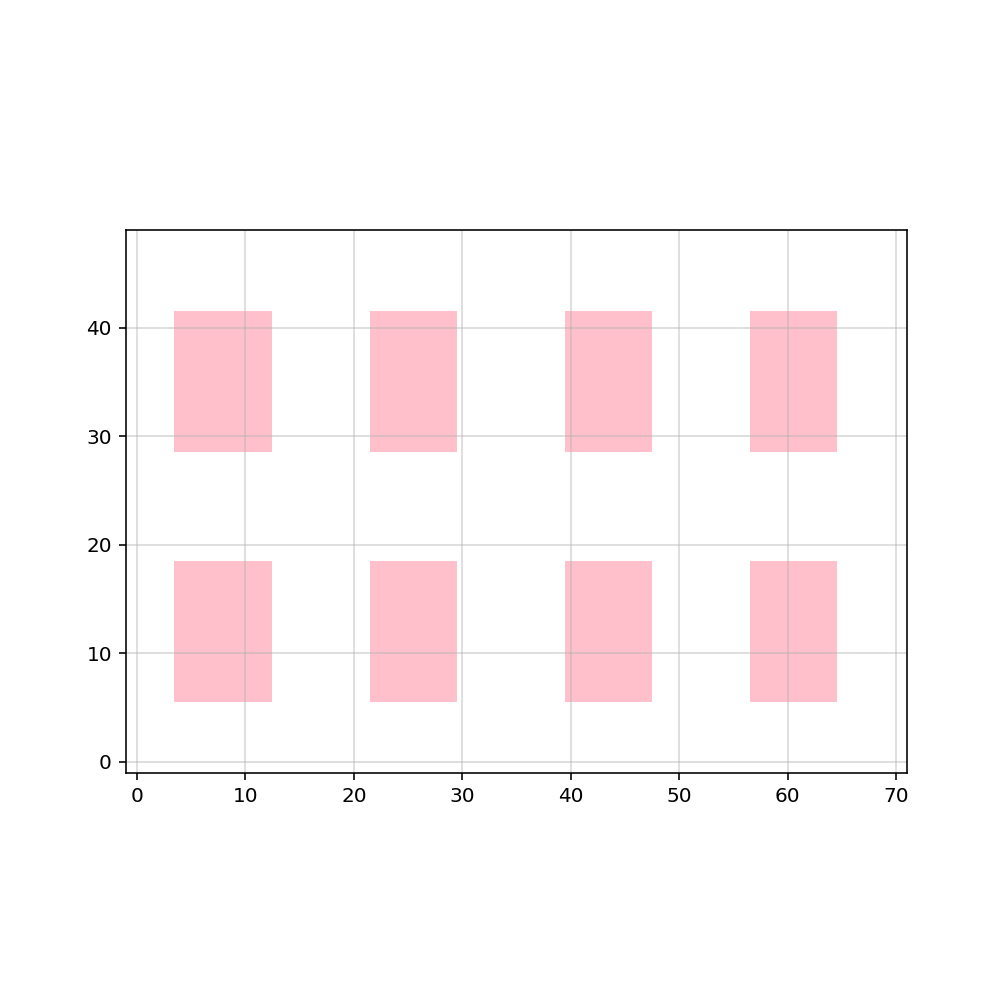

In [22]:
#Creating the grid
fig, ax = create_empty_plot()

# Creating the occupancy grid
#np.random.seed(0) # To guarantee the same outcome on all computers
#data = np.random.rand(max_val, max_val) * 20 # Create a grid of 50 x 50 random values
cmap = colors.ListedColormap(['white', 'pink']) # Select the colors with which to display obstacles and free cells

# Converting the random values into occupied and free cells
limit = 219 
occupancy_grid = thresh.copy()
occupancy_grid[thresh>limit] = 0
occupancy_grid[thresh<=limit] = 1

# Displaying the map
ax.imshow(occupancy_grid.transpose(), cmap=cmap)

# Path Planning

In [23]:
def _get_movements_4n():
    """
    Get all possible 4-connectivity movements.
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid, movement_type="4N", max_val=max_val):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    #for point in [start, goal]:
      #  for coord in point:
       #     assert coord>=0 and coord<max_val, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get possible movements
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet


<IPython.core.display.Javascript object>


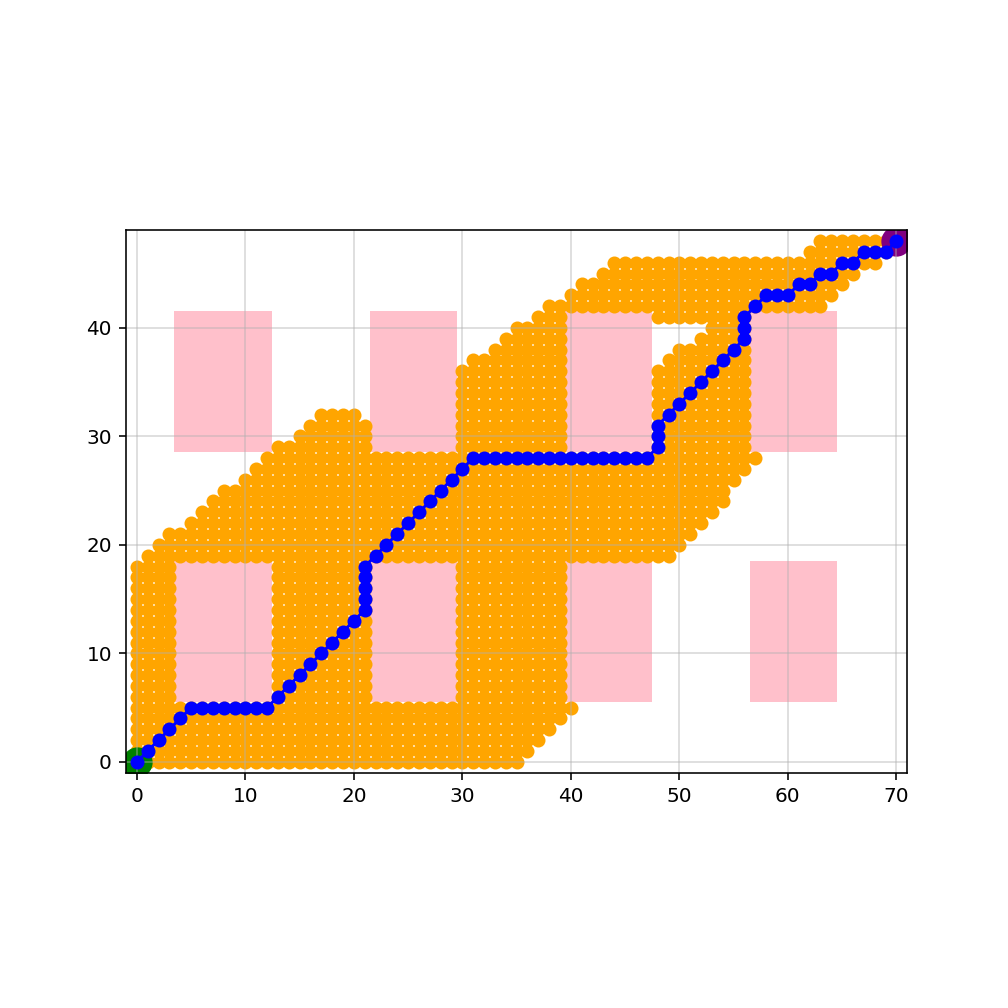

In [24]:
# Define the start and end goal
start = (0,0)
goal = (70,48)

# List of all coordinates in the grid
x,y = np.mgrid[0:L:1, 0:H:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
coords = list([(int(x[0]), int(x[1])) for x in pos])

# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

# Run the A* algorithm
path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, movement_type="8N")
path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Displaying the map
fig_astar, ax_astar = create_empty_plot()
ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);